In [20]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import csv

import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.io import wavfile
import librosa

In [21]:
# Load the model.
model = hub.load('https://tfhub.dev/google/yamnet/1')

# Load the sample audio
!curl -O https://storage.googleapis.com/audioset/speech_whistling2.wav

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  153k  100  153k    0     0  1241k      0 --:--:-- --:--:-- --:--:-- 1240k


In [22]:
# Loading and resampling audio
def load_resample_audio (audio_path, target_sample_rate=16000):

  audio_data, sample_rate = librosa.load(audio_path, sr=None)

  if sample_rate != target_sample_rate:
    audio_data = librosa.resample(audio_data, sample_rate, target_sample_rate)

  return audio_data

In [23]:
# Running yamnet on audio file to get predictions
def yamnet_on_audio(audio_file):

  audio_data = load_resample_audio(audio_file)

  # normalizing waveform
  waveform = audio_data/tf.int16.max

  scores, embeddings, spectogram = model(waveform)

  return scores.numpy(), spectogram.numpy()

In [24]:
# Code from tutorial file
def class_names_from_csv(class_map_csv_text):
  """Returns list of class names corresponding to score vector."""
  class_names = []
  with tf.io.gfile.GFile(class_map_csv_text) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
      class_names.append(row['display_name'])

  return class_names

class_map_path = model.class_map_path().numpy()
class_names = class_names_from_csv(class_map_path)

In [25]:
# # Placeholder function for class selection (hard to select relevant classes without knowing anything about the audio)
# def select_classes(yamnet_classes, selected_classes):

#     selected_class_indices = [yamnet_classes.index(cls) for cls in selected_classes]

#     return selected_class_indices

In [26]:
# Placeholder funtion to plot results (as waveform, spectogram, and top N class scores)
def plot_results(waveform, spectrogram_np, scores_np, class_names):
    plt.figure(figsize=(10, 6))

    # plot the waveform
    plt.subplot(3, 1, 1)
    plt.plot(waveform)
    plt.xlim([0, len(waveform)])

    # plot the log-mel spectrogram
    plt.subplot(3, 1, 2)
    plt.imshow(spectrogram_np.T, aspect='auto', interpolation='nearest', origin='lower')

    # plot and label the model output scores for the top-scoring classes
    mean_scores = np.mean(scores_np, axis=0)
    top_n = 10
    top_class_indices = np.argsort(mean_scores)[::-1][:top_n]
    plt.subplot(3, 1, 3)
    plt.imshow(scores_np[:, top_class_indices].T, aspect='auto', interpolation='nearest', cmap='gray_r')

    plt.xlim([-0.5, scores_np.shape[0] - 0.5])
    yticks = range(0, top_n, 1)
    plt.yticks(yticks, [class_names[top_class_indices[x]] for x in yticks])
    _ = plt.ylim(-0.5 + np.array([top_n, 0]))

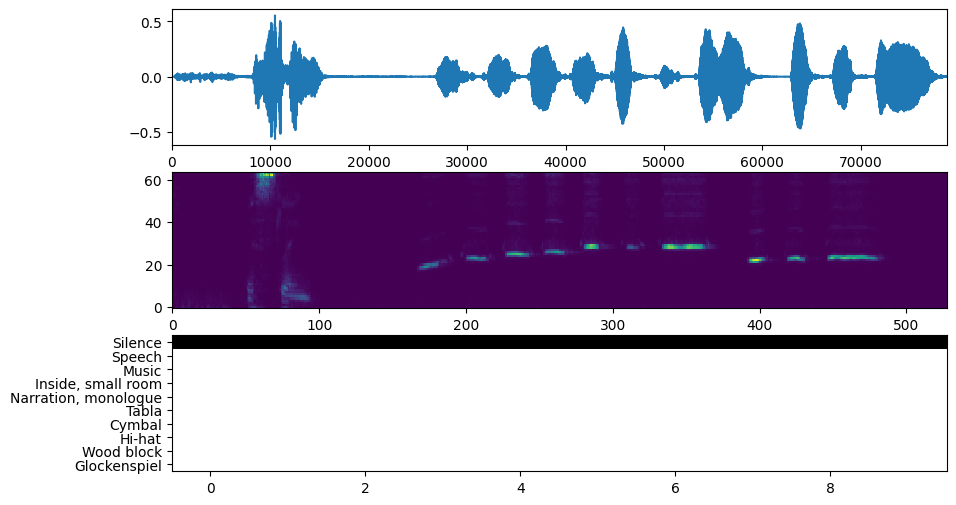

In [27]:
# Example of how to use it (without class filtering, just using sample audio)
audio_file = 'speech_whistling2.wav'
scores, spectrogram_np = yamnet_on_audio(audio_file)

# plotting
plot_results(load_resample_audio(audio_file), spectrogram_np, scores, class_names)